In [1]:
import numpy as np
import matplotlib.pyplot as plt
import queue
import random

# Seed 고정

In [2]:
np.random.seed(100)

In [3]:
random.seed(10)

# Create Job

In [4]:
job_number  = 99

In [5]:
job_time_interval = np.random.poisson(10,job_number)
job_create_time = [sum(job_time_interval[:i]) for i in range(len(job_time_interval)+1)]
print(job_time_interval)
print(job_create_time)
print(len(job_create_time))

[10  9  6 15  7 13 13 13  6 13 11  5 22 15 12 11  7 13  8  9  8  6  3  9
 11 11  9  8 17 12  5 10  9  8 10  5 10  7  7 11 21  7 10 10 10 10  9  9
 10  5 16 10 16  7  7 11 10 11  9  7 10 12  9 11  5 10 10  9  8 10 13 10
  6  9  9 14  8  9 15 10  8  5 12  7 12  8  4  6  9  7 11 11 14 14 12  7
 13  9  6]
[0, 10, 19, 25, 40, 47, 60, 73, 86, 92, 105, 116, 121, 143, 158, 170, 181, 188, 201, 209, 218, 226, 232, 235, 244, 255, 266, 275, 283, 300, 312, 317, 327, 336, 344, 354, 359, 369, 376, 383, 394, 415, 422, 432, 442, 452, 462, 471, 480, 490, 495, 511, 521, 537, 544, 551, 562, 572, 583, 592, 599, 609, 621, 630, 641, 646, 656, 666, 675, 683, 693, 706, 716, 722, 731, 740, 754, 762, 771, 786, 796, 804, 809, 821, 828, 840, 848, 852, 858, 867, 874, 885, 896, 910, 924, 936, 943, 956, 965, 971]
100


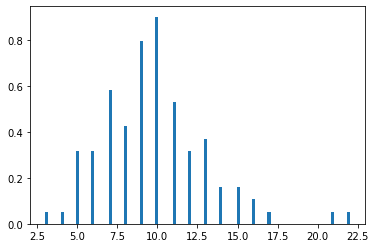

In [6]:
count, bins, ignored = plt.hist(job_time_interval, 100, density = True)
plt.show()

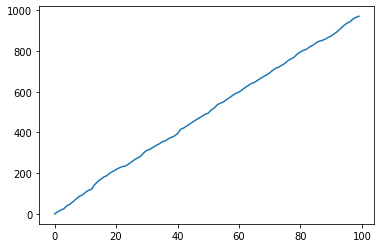

In [7]:
plt.plot(job_create_time)
plt.show()

# Job Queue

In [8]:
class JobQueue(object):
    
    def __init__(self):
        self.job_q = queue.Queue()
        self.job_number = 0
        
    def insertJob(self, inout,  station_dest):
        job = {"inout": inout, "station_dest": station_dest}
        self.job_q.put(job)
        self.job_number+=1

    def getJob(self):
        if self.job_q.empty():
            return 
        self.job_number-=1
        return self.job_q.get()

In [9]:
def job_create(rack_location,total_job_location_list,time,total_job_information):
    job_location = [random.choice(rack_location)]
    if total_job_location_list.count(job_location)%2==0:
        total_job_information['{}'.format(time)] = ['in',job_location]
    else:
        total_job_information['{}'.format(time)] = ['out',job_location]
    total_job_location_list.append(job_location)
    return total_job_information

In [10]:
# def job_create(rack_location,job_create_time,jobQ,total_job_location_list):
#     job_location = [random.choice(rack_location)]
#     if total_job_location_list.count(job_location)%2==0:
#         jobQ.insertJob("in",job_location)
#     else:
#         jobQ.insertJob("out",job_location)
#     total_job_location_list.append(job_location)
#     return jobQ

In [11]:
# ###version2
# ef job_create(rack_location,job_create_time,jobQ,total_job_location_list,time):
#     job_location = [random.choice(rack_location)]
#     total_job_information = {}
#     if total_job_location_list.count(job_location)%2==0:
#         jobQ.insertJob("in",job_location)
#         total_job_information['{}'.format(time)] = ['in',job_location]
#     else:
#         jobQ.insertJob("out",job_location)
#         total_job_information['{}'.format(time)] = ['out',job_location]
#     total_job_location_list.append(job_location)
#     return jobQ, total_job_information

# Auction

In [12]:
class Auction():
    def __init__(self,job,available_agv):
        self.job = job 
        self.available_agv = available_agv
        
    def choose_auctioneer(self,auction_agv_list):
        if len(auction_agv_list) == 0:
            self.auctioneer = random.choice(available_agv)
        
    def select_agv(self,bidding_list):
        self.bidding_list = bidding_list
        min_bid = min(biddling_list)
        target_agv = available_agv.index(min_bid)
        return target_agv
    

# AGV

In [13]:
class AGV(object):
    max_battery = 500
    CHARGING_STATION = [(2,9),(6,9)]    
    
    def __init__(self,agv_id,current_location,current_tick=0):
        self.agv_id = agv_id
        self.battery = self.max_battery
        self.current_location = current_location
        self.job = None
        self.destination = None
        self.available = True
        self.current_tick = current_tick
        self.to_chaging_station = False
        self.charging = False
        
#     def __str__(self):
#         return 'agv_id:{}  job:{}  available:{}'.format(self.agv_id, self.job, self.available)
    
    def __str__(self):
        return 'agv_id:{}'.format(self.agv_id)
    
    def move_one_tick(self):
        if len(self.path) !=0:
            self.next_location = self.path[0]
            self.current_location = self.next_location
            del self.path[0]
            if len(self.path) ==0:
                self.available = True
            self.battery -=1
            self.current_tick +=1
        else:
            self.available = True
            
    def move_one_tick_for_charge(self):
        if len(self.path_for_charge) !=0:
            self.to_chaging_station = True
            self.next_location = self.path_for_charge[0]
            self.current_location = self.next_location
            del self.path_for_charge[0]
            self.battery -=1
            self.current_tick +=1
            if len(self.path_for_charge) ==0:
                self.to_chaging_station = False
                self.charging = True
                self.charging_agv()
        else:
            self.charging = True
    
    def get_job(self,job,astar_path):
        self.job = job
        self.path = astar_path
        self.available = False
        
    def go_to_charge(self,astar_path_to_charger):
        self.path_for_charge = astar_path_to_charger
        self.to_chaging_station = True
    
    
#     def agv_to_charging_station(self,battery_threshold):
#         if self.available == True and self.battery <= battery_threshold:
#             self.to_chaging_station = True

    def calculate_cost(self,agv_id,job,warehouse,INPUT_STATION,OUTPUT_STATION):
        if job['inout']=='in':
            cost = len(astar(warehouse,agv.current_location,INPUT_STATION))
        else:
            cost = len(astar(warehouse,agv.current_location,Rack_enterence[job['station_dest']]))
        return cost        
    
    def calculate_cost_for_charing_bid(self,warehouse,charging_station):
        cost = len(astar(warehouse,self.current_location,charging_station))
        return cost    
    
    def charging_agv(self):
        if self.charging == True:
            self.battery +=50
            if self.battery >= self.max_battery:
                self.battery = self.max_battery
                self.charging = False 
                self.available=True

In [14]:
def getAvailAGV(AGV_LIST,battery_threshold):
    return [agv for agv in AGV_LIST if agv.available == True and agv.battery > battery_threshold]

In [15]:
def getnNeedChargeAgv(AGV_LIST,battery_threshold):
    return [agv for agv in AGV_LIST if agv.available == True and agv.battery <= battery_threshold and agv.charging == False and agv.to_chaging_station == False]

In [16]:
# def agv_to_charging(self,battery_threshold):
#     if self.available = True and self.battery<=battery_threshold:

# Astar

In [17]:
class node:
    def __init__(self,parent=None, position = None):
        self.parent = parent
        self.position = position
        self.g = 0
        self.h = 0
        self.f = 0
    def __eq__(self,other):
        return self.position == other.position

In [18]:
def manhattan_distance(start_node,goal_node):
    dx = abs(start_node[0]-goal_node[0])
    dy = abs(start_node[1]-goal_node[1])
    return dx + dy

In [19]:
def astar(graph,start,goal):
    start_node = node(None,(start[1],start[0]))
    goal_node = node(None,(goal[1],goal[0]))
    open_list = []
    closed_list = []
    graph = [el for el in graph][::-1]
#     for i in graph:
#         print(i)
    
    open_list.append(start_node)
    while open_list:
        current_node = open_list[0]
        current_index = 0
        
        for index, item in enumerate(open_list):
            if item.f < current_node.f:
                current_node = item
                current_index = index
        open_list.pop(current_index)
        closed_list.append(current_node)
        
        if current_node == goal_node:
            path = []
            current = current_node
            while current is not None:
#                 x,y = current.position
#                 graph[x][y] = 9
                path.append((current.position[1],current.position[0]))
                current = current.parent
                
            return path[::-1]
        
        children = []
        for new_position in [(0,1),(1,0),(-1,0),(0,-1)]:
            node_position = (current_node.position[0]+new_position[0],
                             current_node.position[1]+new_position[1])
            within_range = [
                node_position[1]>len(graph)-1,
                node_position[1]<0,
                node_position[0]>len(graph[len(graph)-1])-1,
                node_position[0]<0]
            if any(within_range):
                continue
            if graph[node_position[0]][node_position[1]] !=0:
                continue
            
            new_node = node(current_node, node_position)
            children.append(new_node)
        
        for child in children:
            if child in closed_list:
                continue
            child.g = current_node.g+1
            child.h = manhattan_distance(child.position,goal_node.position)
            child.f = child.g + child.h
            
            if len([open_node for open_node in open_list
                   if child == open_node and child.g>open_node.g]) > 0:
                continue
            open_list.append(child)
            

# Charging station

In [20]:
# class Charging_station(object):
#     CHARGING_STATION = [(2,9),(6,9)]
    
#     def __init__(self,agv_id,current_location,current_tick=0):
#         self.CHARGING_STATION_availbale = True
#         self.battery = self.max_battery
#         self.current_location = current_location
#         self.job = None
#         self.destination = None
#         self.available = True
#         self.current_tick = current_tick
        
#     def charging_station_notavailble():
        

# Warehouse, Rack, Charging_station

In [21]:
def make_warehouse(row,col):
    warehouse = [[0]*col for i in range(row)]
    return warehouse 

In [22]:
def set_rack(warehouse,rack_location):
    for idx, row in enumerate(warehouse):
        warehouse[idx] =  [1 if (ix, ROW -1 - idx) in rack_location else 0 for ix,col in enumerate(warehouse[idx])]

In [23]:
def get4Ways(point):
    return [(point[0],point[1]+1), (point[0]+1,point[1]),
            (point[0],point[1]-1), (point[0]-1,point[1])]

In [24]:
def set_charging_station(warehouse,CHARGING_STATION,ROW,COL):
    for charging_spot in CHARGING_STATION:
        warehouse[ROW-1-charging_spot[1]][charging_spot[0]]=2
    return warehouse

## Make Warehouse, Rack, Rack enterence, Station

In [25]:
ROW, COL = 10,10
warehouse = make_warehouse(ROW,COL)
INPUT_STATION = (3,0)
OUTPUT_STATION = (6,0)
CHARGING_STATION = [(2,9),(7,9)]   
rack_location =  [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7),
                  (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), 
                  (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), 
                  (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), 
                  (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), 
                  (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7)]


In [26]:
set_rack(warehouse,rack_location)
# set_charging_station(warehouse,CHARGING_STATION,ROW,COL)

In [27]:
Rack_enterence={}
for point in rack_location:
    four_ways = get4Ways(point)
    neighbour_obstacle_list = [way for way in four_ways if way in rack_location]  ## 좌표정보 ex) (1,3), (2,2)....
    neighbour_empty_list = [way for way in four_ways if way not in rack_location] 
    if len(neighbour_empty_list) == 1: ### 모서리 아님
        Rack_enterence[point] = neighbour_empty_list[0]
    elif len(neighbour_empty_list) == 2: ### 모서리임
        obstacle_way_list = [four_ways.index(obst) for obst in neighbour_obstacle_list]  ## 방향정보 ex) 0,1, 2...
        for idx, obst_point in enumerate(neighbour_obstacle_list):
            obst_way = obstacle_way_list[idx]
            obst_plus1_point = get4Ways(obst_point)[obst_way]
            if obst_plus1_point in rack_location:
                continue
            else:
                Rack_enterence[point] = four_ways[obst_way-2]
    else:
        print('ERROR finding obstacle/entrance for RACK {}'.format(point))

# 실험

#### Main 함수

In [28]:
print(job_create_time)

[0, 10, 19, 25, 40, 47, 60, 73, 86, 92, 105, 116, 121, 143, 158, 170, 181, 188, 201, 209, 218, 226, 232, 235, 244, 255, 266, 275, 283, 300, 312, 317, 327, 336, 344, 354, 359, 369, 376, 383, 394, 415, 422, 432, 442, 452, 462, 471, 480, 490, 495, 511, 521, 537, 544, 551, 562, 572, 583, 592, 599, 609, 621, 630, 641, 646, 656, 666, 675, 683, 693, 706, 716, 722, 731, 740, 754, 762, 771, 786, 796, 804, 809, 821, 828, 840, 848, 852, 858, 867, 874, 885, 896, 910, 924, 936, 943, 956, 965, 971]


### Simulation condition

In [29]:
jobQ = JobQueue()
jobQ_for_simulation = JobQueue()
run_time = 5000
total_job_location_list = []
select_agv = []
charging_agvs = []
moving_for_charge_agvs = []
battery_threshold = 100
total_job_information = {}

### Create agv

In [30]:
agv1 = AGV("agv1",(0,9))
agv2 = AGV("agv2",(3,9))
agv3 = AGV("agv3",(6,9))
agv4 = AGV("agv4",(9,9))
AGV_LIST = [agv1,agv2,agv3,agv4]
AGV_LIST

### Job_create

In [31]:
job_create_time

[0,
 10,
 19,
 25,
 40,
 47,
 60,
 73,
 86,
 92,
 105,
 116,
 121,
 143,
 158,
 170,
 181,
 188,
 201,
 209,
 218,
 226,
 232,
 235,
 244,
 255,
 266,
 275,
 283,
 300,
 312,
 317,
 327,
 336,
 344,
 354,
 359,
 369,
 376,
 383,
 394,
 415,
 422,
 432,
 442,
 452,
 462,
 471,
 480,
 490,
 495,
 511,
 521,
 537,
 544,
 551,
 562,
 572,
 583,
 592,
 599,
 609,
 621,
 630,
 641,
 646,
 656,
 666,
 675,
 683,
 693,
 706,
 716,
 722,
 731,
 740,
 754,
 762,
 771,
 786,
 796,
 804,
 809,
 821,
 828,
 840,
 848,
 852,
 858,
 867,
 874,
 885,
 896,
 910,
 924,
 936,
 943,
 956,
 965,
 971]

In [32]:
for time in range(run_time+1):
    if time in job_create_time:
        job_create(rack_location,total_job_location_list,time,total_job_information)
print(total_job_information)
print(len(total_job_information))

{'0': ['in', [(8, 2)]], '10': ['in', [(1, 3)]], '19': ['in', [(5, 7)]], '25': ['in', [(7, 3)]], '40': ['out', [(8, 2)]], '47': ['in', [(1, 1)]], '60': ['in', [(2, 7)]], '73': ['in', [(7, 2)]], '86': ['in', [(7, 4)]], '92': ['in', [(4, 4)]], '105': ['in', [(8, 7)]], '116': ['in', [(2, 4)]], '121': ['out', [(1, 3)]], '143': ['in', [(7, 6)]], '158': ['out', [(7, 4)]], '170': ['in', [(4, 7)]], '181': ['in', [(1, 5)]], '188': ['in', [(4, 2)]], '201': ['in', [(5, 3)]], '209': ['in', [(1, 3)]], '218': ['in', [(5, 6)]], '226': ['in', [(2, 2)]], '232': ['in', [(8, 4)]], '235': ['in', [(5, 2)]], '244': ['in', [(5, 4)]], '255': ['out', [(5, 6)]], '266': ['in', [(4, 5)]], '275': ['in', [(4, 3)]], '283': ['out', [(7, 2)]], '300': ['in', [(2, 5)]], '312': ['in', [(4, 6)]], '317': ['out', [(5, 3)]], '327': ['out', [(2, 2)]], '336': ['in', [(7, 2)]], '344': ['out', [(4, 2)]], '354': ['in', [(7, 1)]], '359': ['in', [(8, 5)]], '369': ['out', [(5, 4)]], '376': ['out', [(1, 3)]], '383': ['in', [(8, 3)]], 

In [33]:
for running_time in range(run_time+1):
    if len(moving_for_charge_agvs)!=0:
        for moving_agvs in moving_for_charge_agvs:
            moving_agvs.move_one_tick_for_charge()
            print("running time : {}, moving agv for charging : {}, current location : {}".format(running_time, moving_agvs,moving_agvs.current_location))
            if moving_agvs.charging == True:
                moving_for_charge_agvs.remove(moving_agvs)
                
    agv_need_charge = getnNeedChargeAgv(AGV_LIST,battery_threshold) 
    if len(agv_need_charge)==0:
        print('A time : {}, There is no new AGVs for charge'.format(running_time))
    else:
        print('B There is new AGVs for charging {}'.format(agv_need_charge))          
        for agv_for_charge in agv_need_charge:
            for charger in CHARGING_STATION:
                bid_for_charge_list = []
                bid_for_charge_list.append(agv_for_charge.calculate_cost_for_charing_bid(warehouse,charger))
            min_charger_bid = min(bid_for_charge_list)
            target_charger = CHARGING_STATION[bid_for_charge_list.index(min_charger_bid)]
            astar_path_to_charger = astar(warehouse,agv_for_charge.current_location,target_charger)
            agv_for_charge.go_to_charge(astar_path_to_charger)
            moving_for_charge_agvs.append(agv_for_charge)      
#         print("###",moving_for_charge_agvs)
                    
#       #사용가능한 agv와 job이 있을때 
    if running_time in job_create_time:
        print("@@@@@@@@@@@@@@@@@",running_time)
        jobQ.insertJob(total_job_information.get('{}'.format(running_time))[0],total_job_information.get('{}'.format(running_time))[1][0])
        agv_avail = getAvailAGV(AGV_LIST,battery_threshold)
        print('C running_time : {} , agv_avail : {}'.format(running_time,agv_avail))
        if len(agv_avail)!=0 and jobQ.job_number !=0:
            if running_time ==0 or len(select_agv)==0:
                auctioneer = random.choice(agv_avail)
            else:
                auctioneer = select_agv[-1]
            job = jobQ.getJob()
            bid_list = []
            for agv in agv_avail:
                bid_list.append(agv.calculate_cost(agv,job,warehouse,INPUT_STATION,OUTPUT_STATION))
            min_bid = min(bid_list)
            target_agv = agv_avail[bid_list.index(min_bid)]
            if job['inout']=='in':
                astar_path = astar(warehouse,target_agv.current_location,INPUT_STATION)+astar(warehouse,INPUT_STATION,Rack_enterence[job['station_dest']])
            else:
                astar_path = astar(warehouse,target_agv.current_location,Rack_enterence[job['station_dest']])+astar(warehouse,Rack_enterence[job['station_dest']],OUTPUT_STATION)
            target_agv.get_job(job,astar_path)
            select_agv.append(target_agv)
            print("D running_time : {}, target_agv : {}, target_agv.battery: {}, destination : {}, astar_path : {}, available:{}".format(running_time,target_agv,target_agv.battery,job['station_dest'],astar_path,target_agv.available))
    #           print(auctioneer)
            for moving_agv in set(select_agv):
                moving_agv.move_one_tick()
                if len(moving_agv.path)==0:
                    select_agv.remove(moving_agv)
                print("E time : {}, moving agv : {}, battery : {}, current location : {}".format(running_time,moving_agv,moving_agv.battery,moving_agv.current_location))
        else:
            for moving_agv in select_agv:
                moving_agv.move_one_tick()
                if len(moving_agv.path)==0:
                    select_agv.remove(moving_agv)
                print("F",running_time,moving_agv,moving_agv.battery,moving_agv.current_location)            
                
                
# #         elif len(agv_avail) == 0 and jobQ.job_number = 0  # move one tick 
# #         elif len(agv_avail) == 0 and jobQ.job_number !=0  # move one tick 
# #         elif len(agv_avail) !=0 and jobQ.job_number = 0   # move one tick 
                    
    else:
        agv_avail = getAvailAGV(AGV_LIST,battery_threshold)
        if len(agv_avail)!=0 and jobQ.job_number !=0:
            job = jobQ.getJob()
            bid_list = []
            for agv in agv_avail:
                bid_list.append(agv.calculate_cost(agv,job,warehouse,INPUT_STATION,OUTPUT_STATION))
            min_bid = min(bid_list)
            target_agv = agv_avail[bid_list.index(min_bid)]
            if job['inout']=='in':
                astar_path = astar(warehouse,target_agv.current_location,INPUT_STATION)+astar(warehouse,INPUT_STATION,Rack_enterence[job['station_dest']])
            else:
                astar_path = astar(warehouse,target_agv.current_location,Rack_enterence[job['station_dest']])+astar(warehouse,Rack_enterence[job['station_dest']],OUTPUT_STATION)
            target_agv.get_job(job,astar_path)
            select_agv.append(target_agv)
            print("G running_time : {}, target_agv : {}, target_agv.battery: {}, destination : {}, astar_path : {}, available:{}".format(running_time,target_agv,target_agv.battery,job['station_dest'],astar_path,target_agv.available))
            for moving_agvs in set(select_agv):
                moving_agvs.move_one_tick()
                print("H running time : {} ,moving agvs : {} ,agv battery : {}, moving agv location : {}, agv available{}".format(running_time,moving_agvs, moving_agvs.battery, moving_agvs.current_location, moving_agvs.available))
                if len(moving_agvs.path) ==0:
                    select_agv.remove(moving_agvs)
    #             print("@@@@",moving_agvs,moving_agv.battery,moving_agv.current_location)
        
        else:
            for moving_agv in select_agv:
                if len(moving_agv.path)!=0:
                    moving_agv.move_one_tick()
                else:
                    del select_agv[select_agv.index(moving_agv)]
                print("I",running_time,moving_agv,moving_agv.battery,moving_agv.current_location)          

A time : 0, There is no new AGVs for charge
@@@@@@@@@@@@@@@@@ 0
C running_time : 0 , agv_avail : [<__main__.AGV object at 0x00000255502475C8>, <__main__.AGV object at 0x0000025550247DC8>, <__main__.AGV object at 0x0000025550270208>, <__main__.AGV object at 0x00000255502701C8>]
D running_time : 0, target_agv : agv_id:agv2, target_agv.battery: 500, destination : (8, 2), astar_path : [(3, 9), (3, 8), (3, 7), (3, 6), (3, 5), (3, 4), (3, 3), (3, 2), (3, 1), (3, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (9, 1), (9, 2)], available:False
E time : 0, moving agv : agv_id:agv2, battery : 499, current location : (3, 9)
A time : 1, There is no new AGVs for charge
I 1 agv_id:agv2 498 (3, 8)
A time : 2, There is no new AGVs for charge
I 2 agv_id:agv2 497 (3, 7)
A time : 3, There is no new AGVs for charge
I 3 agv_id:agv2 496 (3, 6)
A time : 4, There is no new AGVs for charge
I 4 agv_id:agv2 495 (3, 5)
A time : 5, There is no new AGVs for charge
I 5 agv_id:agv2 494 (3, 4)
A time : 6, 

I 189 agv_id:agv4 418 (3, 6)
A time : 190, There is no new AGVs for charge
I 190 agv_id:agv1 420 (0, 1)
I 190 agv_id:agv4 417 (3, 5)
A time : 191, There is no new AGVs for charge
I 191 agv_id:agv1 419 (0, 2)
I 191 agv_id:agv4 416 (3, 4)
A time : 192, There is no new AGVs for charge
I 192 agv_id:agv1 418 (0, 3)
I 192 agv_id:agv4 415 (3, 3)
A time : 193, There is no new AGVs for charge
I 193 agv_id:agv1 417 (0, 4)
I 193 agv_id:agv4 414 (3, 2)
A time : 194, There is no new AGVs for charge
I 194 agv_id:agv1 416 (0, 5)
I 194 agv_id:agv4 413 (3, 1)
A time : 195, There is no new AGVs for charge
I 195 agv_id:agv1 416 (0, 5)
A time : 196, There is no new AGVs for charge
I 196 agv_id:agv4 412 (3, 0)
A time : 197, There is no new AGVs for charge
I 197 agv_id:agv4 411 (3, 0)
A time : 198, There is no new AGVs for charge
I 198 agv_id:agv4 410 (3, 1)
A time : 199, There is no new AGVs for charge
I 199 agv_id:agv4 409 (3, 2)
A time : 200, There is no new AGVs for charge
I 200 agv_id:agv4 409 (3, 2)
A

I 240 agv_id:agv1 376 (9, 4)
I 240 agv_id:agv4 371 (3, 0)
A time : 241, There is no new AGVs for charge
I 241 agv_id:agv4 370 (4, 0)
I 241 agv_id:agv1 376 (9, 4)
A time : 242, There is no new AGVs for charge
I 242 agv_id:agv4 369 (5, 0)
I 242 agv_id:agv4 368 (6, 0)
A time : 243, There is no new AGVs for charge
I 243 agv_id:agv4 367 (6, 1)
I 243 agv_id:agv4 366 (6, 2)
A time : 244, There is no new AGVs for charge
@@@@@@@@@@@@@@@@@ 244
C running_time : 244 , agv_avail : [<__main__.AGV object at 0x00000255502475C8>, <__main__.AGV object at 0x0000025550247DC8>, <__main__.AGV object at 0x0000025550270208>, <__main__.AGV object at 0x00000255502701C8>]
D running_time : 244, target_agv : agv_id:agv4, target_agv.battery: 366, destination : (5, 4), astar_path : [(6, 2), (6, 1), (6, 0), (5, 0), (4, 0), (3, 0), (3, 0), (4, 0), (5, 0), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4)], available:False
E time : 244, moving agv : agv_id:agv4, battery : 365, current location : (6, 2)
A time : 245, There is no n

E time : 376, moving agv : agv_id:agv3, battery : 417, current location : (6, 0)
E time : 376, moving agv : agv_id:agv2, battery : 416, current location : (9, 5)
E time : 376, moving agv : agv_id:agv1, battery : 333, current location : (6, 1)
A time : 377, There is no new AGVs for charge
I 377 agv_id:agv1 332 (6, 0)
A time : 378, There is no new AGVs for charge
I 378 agv_id:agv1 331 (5, 0)
A time : 379, There is no new AGVs for charge
I 379 agv_id:agv1 330 (4, 0)
A time : 380, There is no new AGVs for charge
I 380 agv_id:agv1 329 (3, 0)
A time : 381, There is no new AGVs for charge
I 381 agv_id:agv1 328 (2, 0)
A time : 382, There is no new AGVs for charge
I 382 agv_id:agv1 327 (1, 0)
A time : 383, There is no new AGVs for charge
@@@@@@@@@@@@@@@@@ 383
C running_time : 383 , agv_avail : [<__main__.AGV object at 0x0000025550247DC8>, <__main__.AGV object at 0x0000025550270208>, <__main__.AGV object at 0x00000255502701C8>]
D running_time : 383, target_agv : agv_id:agv3, target_agv.battery: 

I 564 agv_id:agv3 371 (6, 0)
I 564 agv_id:agv2 373 (4, 0)
A time : 565, There is no new AGVs for charge
I 565 agv_id:agv3 371 (6, 0)
A time : 566, There is no new AGVs for charge
I 566 agv_id:agv2 372 (3, 0)
A time : 567, There is no new AGVs for charge
I 567 agv_id:agv2 371 (3, 0)
A time : 568, There is no new AGVs for charge
I 568 agv_id:agv2 370 (3, 1)
A time : 569, There is no new AGVs for charge
I 569 agv_id:agv2 369 (3, 2)
A time : 570, There is no new AGVs for charge
I 570 agv_id:agv2 368 (3, 3)
A time : 571, There is no new AGVs for charge
I 571 agv_id:agv2 367 (3, 4)
A time : 572, There is no new AGVs for charge
@@@@@@@@@@@@@@@@@ 572
C running_time : 572 , agv_avail : [<__main__.AGV object at 0x00000255502475C8>, <__main__.AGV object at 0x0000025550270208>, <__main__.AGV object at 0x00000255502701C8>]
D running_time : 572, target_agv : agv_id:agv1, target_agv.battery: 217, destination : (7, 5), astar_path : [(6, 0), (5, 0), (4, 0), (3, 0), (3, 0), (4, 0), (5, 0), (6, 0), (6, 1

A time : 632, There is no new AGVs for charge
I 632 agv_id:agv4 275 (4, 0)
A time : 633, There is no new AGVs for charge
I 633 agv_id:agv4 274 (3, 0)
A time : 634, There is no new AGVs for charge
I 634 agv_id:agv4 273 (2, 0)
A time : 635, There is no new AGVs for charge
I 635 agv_id:agv4 272 (1, 0)
A time : 636, There is no new AGVs for charge
I 636 agv_id:agv4 271 (0, 0)
A time : 637, There is no new AGVs for charge
I 637 agv_id:agv4 270 (0, 1)
A time : 638, There is no new AGVs for charge
I 638 agv_id:agv4 269 (0, 2)
A time : 639, There is no new AGVs for charge
I 639 agv_id:agv4 268 (0, 3)
A time : 640, There is no new AGVs for charge
I 640 agv_id:agv4 267 (0, 3)
A time : 641, There is no new AGVs for charge
@@@@@@@@@@@@@@@@@ 641
C running_time : 641 , agv_avail : [<__main__.AGV object at 0x00000255502475C8>, <__main__.AGV object at 0x0000025550247DC8>, <__main__.AGV object at 0x0000025550270208>]
D running_time : 641, target_agv : agv_id:agv2, target_agv.battery: 335, destination :

I 756 agv_id:agv1 169 (0, 3)
A time : 757, There is no new AGVs for charge
I 757 agv_id:agv4 211 (5, 0)
I 757 agv_id:agv1 168 (0, 2)
A time : 758, There is no new AGVs for charge
I 758 agv_id:agv4 210 (6, 0)
I 758 agv_id:agv1 167 (0, 1)
A time : 759, There is no new AGVs for charge
I 759 agv_id:agv4 210 (6, 0)
A time : 760, There is no new AGVs for charge
I 760 agv_id:agv1 166 (0, 0)
A time : 761, There is no new AGVs for charge
I 761 agv_id:agv1 165 (1, 0)
A time : 762, There is no new AGVs for charge
@@@@@@@@@@@@@@@@@ 762
C running_time : 762 , agv_avail : [<__main__.AGV object at 0x0000025550247DC8>, <__main__.AGV object at 0x0000025550270208>, <__main__.AGV object at 0x00000255502701C8>]
D running_time : 762, target_agv : agv_id:agv4, target_agv.battery: 210, destination : (1, 7), astar_path : [(6, 0), (5, 0), (4, 0), (3, 0), (3, 0), (2, 0), (1, 0), (0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7)], available:False
E time : 762, moving agv : agv_id:agv1, battery : 164

I 914 agv_id:agv3 240 (6, 1)
A time : 915, There is no new AGVs for charge
I 915 agv_id:agv3 239 (6, 0)
A time : 916, There is no new AGVs for charge
I 916 agv_id:agv3 239 (6, 0)
A time : 917, There is no new AGVs for charge
A time : 918, There is no new AGVs for charge
A time : 919, There is no new AGVs for charge
A time : 920, There is no new AGVs for charge
A time : 921, There is no new AGVs for charge
A time : 922, There is no new AGVs for charge
A time : 923, There is no new AGVs for charge
A time : 924, There is no new AGVs for charge
@@@@@@@@@@@@@@@@@ 924
C running_time : 924 , agv_avail : [<__main__.AGV object at 0x00000255502475C8>, <__main__.AGV object at 0x0000025550247DC8>, <__main__.AGV object at 0x0000025550270208>, <__main__.AGV object at 0x00000255502701C8>]
D running_time : 924, target_agv : agv_id:agv2, target_agv.battery: 269, destination : (4, 6), astar_path : [(3, 4), (3, 5), (3, 6), (3, 6), (3, 5), (3, 4), (3, 3), (3, 2), (3, 1), (3, 0), (4, 0), (5, 0), (6, 0)], a

A time : 2033, There is no new AGVs for charge
A time : 2034, There is no new AGVs for charge
A time : 2035, There is no new AGVs for charge
A time : 2036, There is no new AGVs for charge
A time : 2037, There is no new AGVs for charge
A time : 2038, There is no new AGVs for charge
A time : 2039, There is no new AGVs for charge
A time : 2040, There is no new AGVs for charge
A time : 2041, There is no new AGVs for charge
A time : 2042, There is no new AGVs for charge
A time : 2043, There is no new AGVs for charge
A time : 2044, There is no new AGVs for charge
A time : 2045, There is no new AGVs for charge
A time : 2046, There is no new AGVs for charge
A time : 2047, There is no new AGVs for charge
A time : 2048, There is no new AGVs for charge
A time : 2049, There is no new AGVs for charge
A time : 2050, There is no new AGVs for charge
A time : 2051, There is no new AGVs for charge
A time : 2052, There is no new AGVs for charge
A time : 2053, There is no new AGVs for charge
A time : 2054

A time : 2320, There is no new AGVs for charge
A time : 2321, There is no new AGVs for charge
A time : 2322, There is no new AGVs for charge
A time : 2323, There is no new AGVs for charge
A time : 2324, There is no new AGVs for charge
A time : 2325, There is no new AGVs for charge
A time : 2326, There is no new AGVs for charge
A time : 2327, There is no new AGVs for charge
A time : 2328, There is no new AGVs for charge
A time : 2329, There is no new AGVs for charge
A time : 2330, There is no new AGVs for charge
A time : 2331, There is no new AGVs for charge
A time : 2332, There is no new AGVs for charge
A time : 2333, There is no new AGVs for charge
A time : 2334, There is no new AGVs for charge
A time : 2335, There is no new AGVs for charge
A time : 2336, There is no new AGVs for charge
A time : 2337, There is no new AGVs for charge
A time : 2338, There is no new AGVs for charge
A time : 2339, There is no new AGVs for charge
A time : 2340, There is no new AGVs for charge
A time : 2341

A time : 3513, There is no new AGVs for charge
A time : 3514, There is no new AGVs for charge
A time : 3515, There is no new AGVs for charge
A time : 3516, There is no new AGVs for charge
A time : 3517, There is no new AGVs for charge
A time : 3518, There is no new AGVs for charge
A time : 3519, There is no new AGVs for charge
A time : 3520, There is no new AGVs for charge
A time : 3521, There is no new AGVs for charge
A time : 3522, There is no new AGVs for charge
A time : 3523, There is no new AGVs for charge
A time : 3524, There is no new AGVs for charge
A time : 3525, There is no new AGVs for charge
A time : 3526, There is no new AGVs for charge
A time : 3527, There is no new AGVs for charge
A time : 3528, There is no new AGVs for charge
A time : 3529, There is no new AGVs for charge
A time : 3530, There is no new AGVs for charge
A time : 3531, There is no new AGVs for charge
A time : 3532, There is no new AGVs for charge
A time : 3533, There is no new AGVs for charge
A time : 3534

A time : 3870, There is no new AGVs for charge
A time : 3871, There is no new AGVs for charge
A time : 3872, There is no new AGVs for charge
A time : 3873, There is no new AGVs for charge
A time : 3874, There is no new AGVs for charge
A time : 3875, There is no new AGVs for charge
A time : 3876, There is no new AGVs for charge
A time : 3877, There is no new AGVs for charge
A time : 3878, There is no new AGVs for charge
A time : 3879, There is no new AGVs for charge
A time : 3880, There is no new AGVs for charge
A time : 3881, There is no new AGVs for charge
A time : 3882, There is no new AGVs for charge
A time : 3883, There is no new AGVs for charge
A time : 3884, There is no new AGVs for charge
A time : 3885, There is no new AGVs for charge
A time : 3886, There is no new AGVs for charge
A time : 3887, There is no new AGVs for charge
A time : 3888, There is no new AGVs for charge
A time : 3889, There is no new AGVs for charge
A time : 3890, There is no new AGVs for charge
A time : 3891

In [34]:
# for running_time in range(run_time+1):
#     if running_time in job_create_time:
#         jobQ.insertJob(total_job_information.get('{}'.format(running_time))[0],total_job_information.get('{}'.format(running_time))[1][0])
#         agv_avail = getAvailAGV(AGV_LIST,battery_threshold)
#         agv_need_charge = getnNeedChargeAgv(AGV_LIST,battery_threshold) 
#         print('need charge',agv_need_charge)
#         print('running_time : {} , agv_avail : {}'.format(running_time,agv_avail))
#         if len(agv_need_charge)==0:
#             print('There is no AGV for charge')
#         else:
#             print('There is  AGV for charge')          
#             for agv_for_charge in agv_need_charge:
#                 for charger in CHARGING_STATION:
#                     bid_for_charge_list = []
#                     bid_for_charge_list.append(agv_for_charge.calculate_cost_for_charing_bid(warehouse,charger))
#                 min_charger_bid = min(bid_for_charge_list)
#                 targer_charger = CHARGING_STATION[bid_for_charge_list.index(min_charger_bid)]
#                 astar_path_to_charger = astar(warehouse,agv_for_charge.current_location,targer_charger)
# #                 print('agv for charge : {}, targer charger : {} , astar path to charger : {}'.format(agv_for_charge,targer_charger,astar_path_to_charger))
#                 agv_for_charge.go_to_charge(astar_path_to_charger)
#                 agv_for_charge.move_one_tick_for_charge()       
#                 print('agv for charge : {}, targer charger : {} , agv for charge current location : {}'.format(agv_for_charge,targer_charger,agv_for_charge.current_location))
#         #사용가능한 agv와 job이 있을때 
#         if len(agv_avail)!=0 and jobQ.job_number !=0:
#             if running_time ==0:
#                 auctioneer = random.choice(agv_avail)
#             else:
#                 auctioneer = select_agv[-1]
#             job = jobQ.getJob()
#             bid_list = []
#             for agv in agv_avail:
#                 bid_list.append(agv.calculate_cost(agv,job,warehouse,INPUT_STATION,OUTPUT_STATION))
#             min_bid = min(bid_list)
#             target_agv = agv_avail[bid_list.index(min_bid)]
#             if job['inout']=='in':
#                 astar_path = astar(warehouse,target_agv.current_location,INPUT_STATION)+astar(warehouse,INPUT_STATION,Rack_enterence[job['station_dest']])
#             else:
#                 astar_path = astar(warehouse,target_agv.current_location,Rack_enterence[job['station_dest']])+astar(warehouse,Rack_enterence[job['station_dest']],OUTPUT_STATION)
#             target_agv.get_job(job,astar_path)
#             select_agv.append(target_agv)
#             print("target_agv : {}, target_agv.battery: {} ,astar_path : {}, available:{}".format(target_agv,target_agv.battery,astar_path,target_agv.available))
#     #           print(auctioneer)
#             for moving_agv in select_agv:
#                 moving_agv.move_one_tick()
#                 if len(moving_agv.path)==0:
#                     del select_agv[select_agv.index(moving_agv)]
#                 print("@@",moving_agv,moving_agv.battery,moving_agv.current_location)
            
                
# # #         elif len(agv_avail) == 0 and jobQ.job_number = 0  # move one tick 
# # #         elif len(agv_avail) == 0 and jobQ.job_number !=0  # move one tick 
# # #         elif len(agv_avail) !=0 and jobQ.job_number = 0   # move one tick 
                    
#     else:
#         for moving_agvs in select_agv:
#             moving_agvs.move_one_tick()
#             print("moving agvs : {} ,agv battery : {}, moving agv location : {}, agv available{}".format(moving_agvs, moving_agvs.battery, moving_agvs.current_location, moving_agvs.available))
#             if len(moving_agvs.path) ==0:
#                 del select_agv[select_agv.index(moving_agvs)]
# #             print("@@@@",moving_agvs,moving_agv.battery,moving_agv.current_location)
        

In [35]:
# ## 기존것 (구현된 것)
# for running_time in range(run_time+1):
#     if running_time in job_create_time:
#         jobQ.insertJob(total_job_information.get('{}'.format(running_time))[0],total_job_information.get('{}'.format(running_time))[1][0])
#         agv_avail = getAvailAGV(AGV_LIST,battery_threshold)
#         print(agv_avail)
#         #사용가능한 agv와 job이 있을때 
#         if len(agv_avail)!=0 and jobQ.job_number !=0:
#             if running_time ==0:
#                 auctioneer = random.choice(agv_avail)
#             else:
#                 auctioneer = select_agv[-1]
#             job = jobQ.getJob()
#             bid_list = []
#             for agv in agv_avail:
#                 bid_list.append(agv.calculate_cost(agv,job,warehouse,INPUT_STATION,OUTPUT_STATION))
#             min_bid = min(bid_list)
#             target_agv = agv_avail[bid_list.index(min_bid)]
#             if job['inout']=='in':
#                 astar_path = astar(warehouse,target_agv.current_location,INPUT_STATION)+astar(warehouse,INPUT_STATION,Rack_enterence[job['station_dest']])
#             else:
#                 astar_path = astar(warehouse,target_agv.current_location,Rack_enterence[job['station_dest']])+astar(warehouse,Rack_enterence[job['station_dest']],OUTPUT_STATION)
#             target_agv.get_job(job,astar_path)
#             select_agv.append(target_agv)
#             print("target_agv : {}, target_agv.battery: {} ,astar_path : {}, available:{}".format(target_agv,target_agv.battery,astar_path,target_agv.available))
#     #           print(auctioneer)
#             for moving_agv in select_agv:
#                 moving_agv.move_one_tick()
#                 print("@@",moving_agv,moving_agv.battery,moving_agv.current_location)
                    
#     else:
#         for moving_agvs in select_agv:
#             moving_agvs.move_one_tick()
#             print("moving agvs {} , agv battery : {}, moving agv location{}, agv available {}".format(moving_agvs, moving_agvs.battery,moving_agvs.current_location, moving_agvs.available))
# #             if len(moving_agvs.path) ==1:
# #                 del select_agv[select_agv.index(moving_agvs)]
# #             print("@@@@",moving_agvs,moving_agv.battery,moving_agv.current_location)
        

In [36]:
# for time in range(run_time+1):
#     if time in job_create_time:
#         job_create(rack_location,job_create_time,jobQ,total_job_location_list)
#         agv_avail = getAvailAGV(AGV_LIST,battery_threshold)
#         print(agv_avail)
#         if len(agv_avail)!=0 and jobQ.job_number !=0:
#             if time ==0:
#                 auctioneer = random.choice(agv_avail)
#             else:
#                 auctioneer = select_agv[-1]
#             job = jobQ.getJob()
#             print(job)
#             bid_list = []
#             for agv in agv_avail:
#                 bid_list.append(agv.calculate_cost(agv,job,warehouse,INPUT_STATION,OUTPUT_STATION))
#             min_bid = min(bid_list)
#             target_agv = agv_avail[bid_list.index(min_bid)]
#             if job['inout']=='in':
#                 astar_path = astar(warehouse,target_agv.current_location,INPUT_STATION)+astar(warehouse,INPUT_STATION,Rack_enterence[job['station_dest'][0]])
#             else:
#                 astar_path = astar(warehouse,target_agv.current_location,Rack_enterence[job['station_dest'][0]])+astar(warehouse,Rack_enterence[job['station_dest'][0]],OUTPUT_STATION)
#             target_agv.get_job(job,astar_path)
#             select_agv.append(target_agv)
#             print("target_agv : {}, target_agv.battery: {} ,astar_path : {}, available:{}".format(target_agv,target_agv.battery,astar_path,target_agv.available))
# #             print(auctioneer)
#             for moving_agv in select_agv:
#                 moving_agv.move_one_tick()
#                 print("@@",moving_agv,moving_agv.battery,moving_agv.current_location)
#     else:
#         for moving_agvs in select_agv:
#             moving_agvs.move_one_tick()
#             print("moving agvs : {} ,agv battery : {} ,moving agv location{} , agv available : {}".format(moving_agvs, moving_agvs.battery,moving_agvs.current_location, moving_agvs.available))
# #             if len(moving_agvs.path) ==1:
# #                 del select_agv[select_agv.index(moving_agvs)]
# #             print("@@@@",moving_agvs,moving_agv.battery,moving_agv.current_location)

In [37]:
# ### job이 알려지지 않은 채로 생성될 때 
# for time in range(run_time+1):
#     if time in job_create_time:
#         job_create(rack_location,job_create_time,jobQ,total_job_location_list)
#         agv_avail = getAvailAGV(AGV_LIST,battery_threshold)
#         print(agv_avail)
#         if len(agv_avail)!=0 and jobQ.job_number !=0:
#             if time ==0:
#                 auctioneer = random.choice(agv_avail)
#             else:
#                 auctioneer = select_agv[-1]
#             job = jobQ.getJob()
#             print(job)
#             bid_list = []
#             for agv in agv_avail:
#                 bid_list.append(agv.calculate_cost(agv,job,warehouse,INPUT_STATION,OUTPUT_STATION))
#             min_bid = min(bid_list)
#             target_agv = agv_avail[bid_list.index(min_bid)]
#             if job['inout']=='in':
#                 astar_path = astar(warehouse,target_agv.current_location,INPUT_STATION)+astar(warehouse,INPUT_STATION,Rack_enterence[job['station_dest'][0]])
#             else:
#                 astar_path = astar(warehouse,target_agv.current_location,Rack_enterence[job['station_dest'][0]])+astar(warehouse,Rack_enterence[job['station_dest'][0]],OUTPUT_STATION)
#             target_agv.get_job(job,astar_path)
#             select_agv.append(target_agv)
#             print("target_agv : {}, target_agv.battery: {} ,astar_path : {}, available:{}".format(target_agv,target_agv.battery,astar_path,target_agv.available))
# #             print(auctioneer)
#             for moving_agv in select_agv:
#                 moving_agv.move_one_tick()
#                 print("@@",moving_agv,moving_agv.battery,moving_agv.current_location)
#     else:
#         for moving_agvs in select_agv:
#             moving_agvs.move_one_tick()
#             print("moving agvs : {} ,agv battery : {} ,moving agv location{} , agv available : {}".format(moving_agvs, moving_agvs.battery,moving_agvs.current_location, moving_agvs.available))
# #             if len(moving_agvs.path) ==1:
# #                 del select_agv[select_agv.index(moving_agvs)]
# #             print("@@@@",moving_agvs,moving_agv.battery,moving_agv.current_location)
        